In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import math

In [2]:
# Функция будет искать черные рамки на изображениях.
def find_blackbox(path, dirname, subdirname ,file_name):
    img = cv2.imread(path)
        
    dir_name = dirname
    subdir_name = subdirname
    
    low = (0,0,0)   # Нижний диапазон цвета (черный) 
    high = (0,0,255) # Верхний диапазон цвета (красный). Красный взят из-за сетки красного цвета на разных изображаениях.
    
    # Фильтрация изображения с ранее выбранными диапазонами цвета. 
    only_bb = cv2.inRange(img, low, high)
    
    # Делаем размытие, чтобы улучшить поиск черных областей при наличии красной сетки
    only_bb = cv2.GaussianBlur(only_bb, (3, 3), 0)
        
    # Ищем контуры
    contours0, hierarchy = cv2.findContours(only_bb, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    img1 = img
    
    for cnt in contours0:
        rect = cv2.minAreaRect(cnt) # пытаемся вписать прямоугольник
        box = cv2.boxPoints(rect) # поиск четырех вершин прямоугольника
        box = np.int0(box) # округление координат
        area = int(rect[1][0]*rect[1][1]) # вычисление площади прямоугольника, нужно чтобы не учитывать слишком маленькие
        
        if area > 7000:
            # вычисление координат двух векторов, являющихся сторонам прямоугольника
            edge1 = np.int0((box[1][0] - box[0][0],box[1][1] - box[0][1]))
            edge2 = np.int0((box[2][0] - box[1][0], box[2][1] - box[1][1]))
            
            # выясняем какой вектор меньше
            usedEdge = edge1
            if cv2.norm(edge2) < cv2.norm(edge1):
                usedEdge = edge2
            
            reference = (1,0) # горизонтальный вектор, задающий горизонт
            
            # ищем угол между горизонтом и короткой стороной прямоугольника
            angle = 180.0/math.pi * math.acos((reference[0]*usedEdge[0] + reference[1]*usedEdge[1]) / (cv2.norm(reference) *cv2.norm(usedEdge)))    
        
           
            # Оставляем только те прямоугльники, где короткая сторона параллельна горизонту (чтобы убрать артефакты с прямоугольниками под углом) 
            if angle <182 and angle > 178 or angle <2:
                
                cv2.drawContours(img1,[box],0,(0,255,0),2) # рисуем прямоугольник
            
    
    
    cv2.imwrite('out/'+ dir_name +"/"+ subdir_name+ "/" + file_name, img1)  # Сохраняем картинку с отрисованными контурами в папке

In [3]:
# Список имен папок
# Использовал фото только из первых двух папок.
dir_list = ['60img','600img']

# Список имен подпапок
subdir_list = ['G32V0H0','G32V3H0','G32V7H0','G32V11H0']
                       
# Проходим по каждой папке, подпапке и каждому файлу в ней. Применяем к файлу функцию.

for dir_name in dir_list:
    os.mkdir('out/'+dir_name)
    for subdir_name in subdir_list:
        
        os.mkdir('out/'+dir_name+ "/"+ subdir_name) # Создадим папку куда будем сохранять картинки с найденными прямоугольниками.
        files_list = os.listdir(path= dir_name+"/"+subdir_name)
    
        for file in files_list:
            find_blackbox(dir_name +'/'+ subdir_name + "/" +file, dir_name, subdir_name ,file)
    



In [1]:
# Посмотрим на некоторые результаты рабоы скрипта.

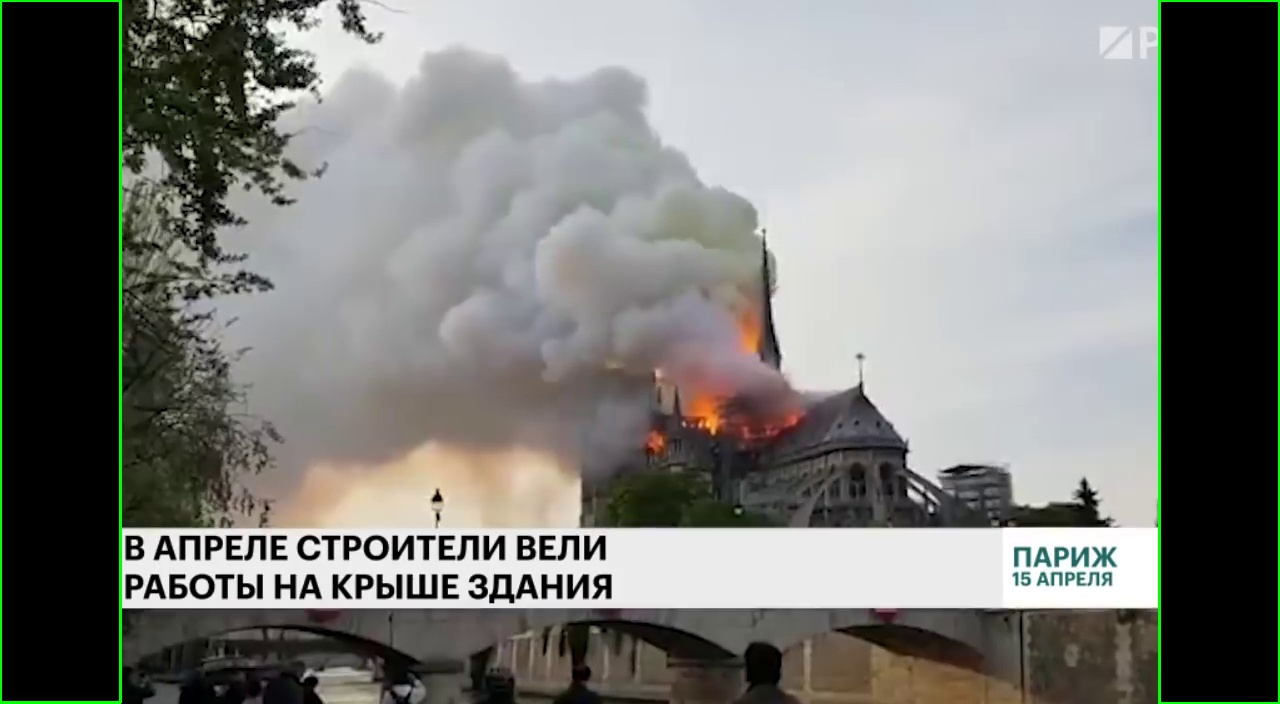

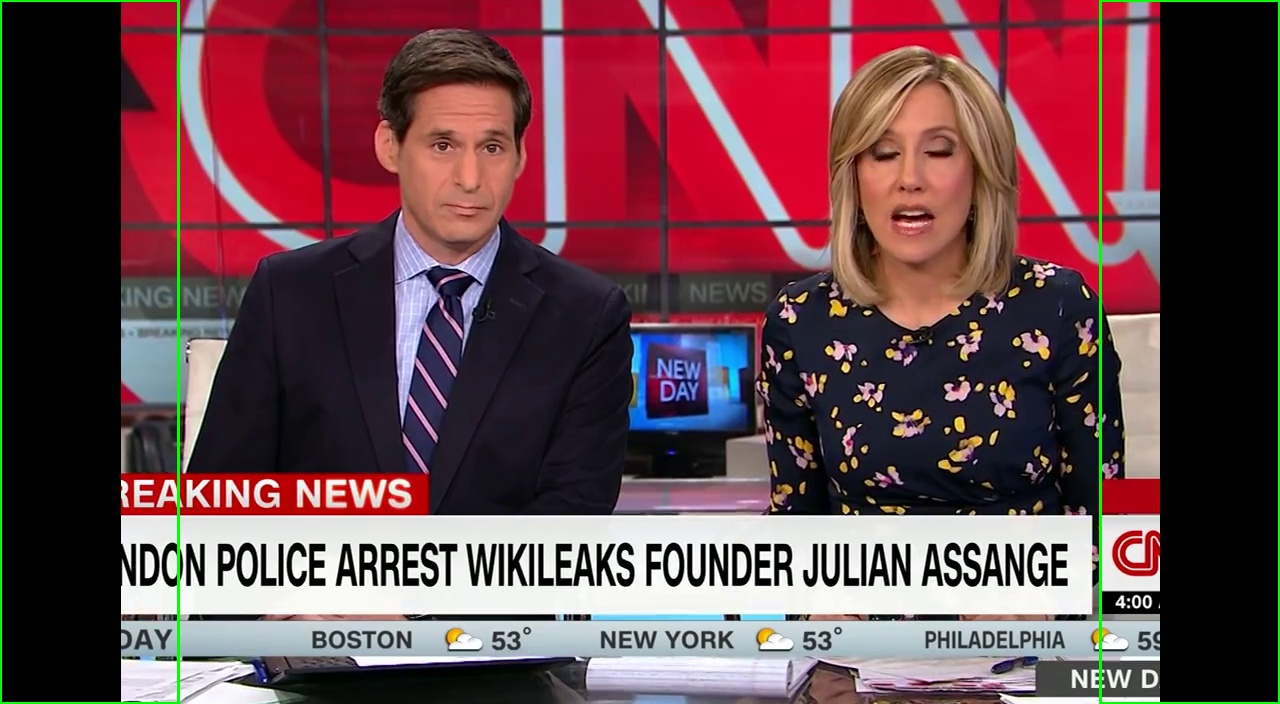

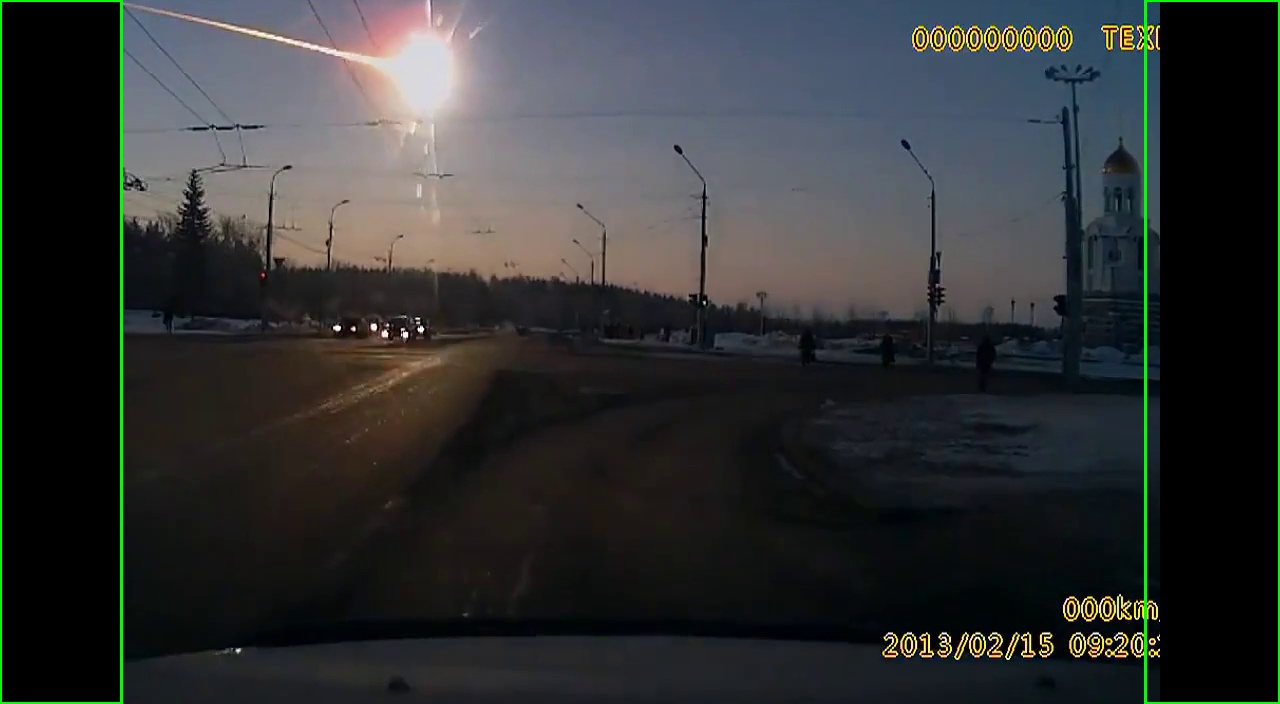

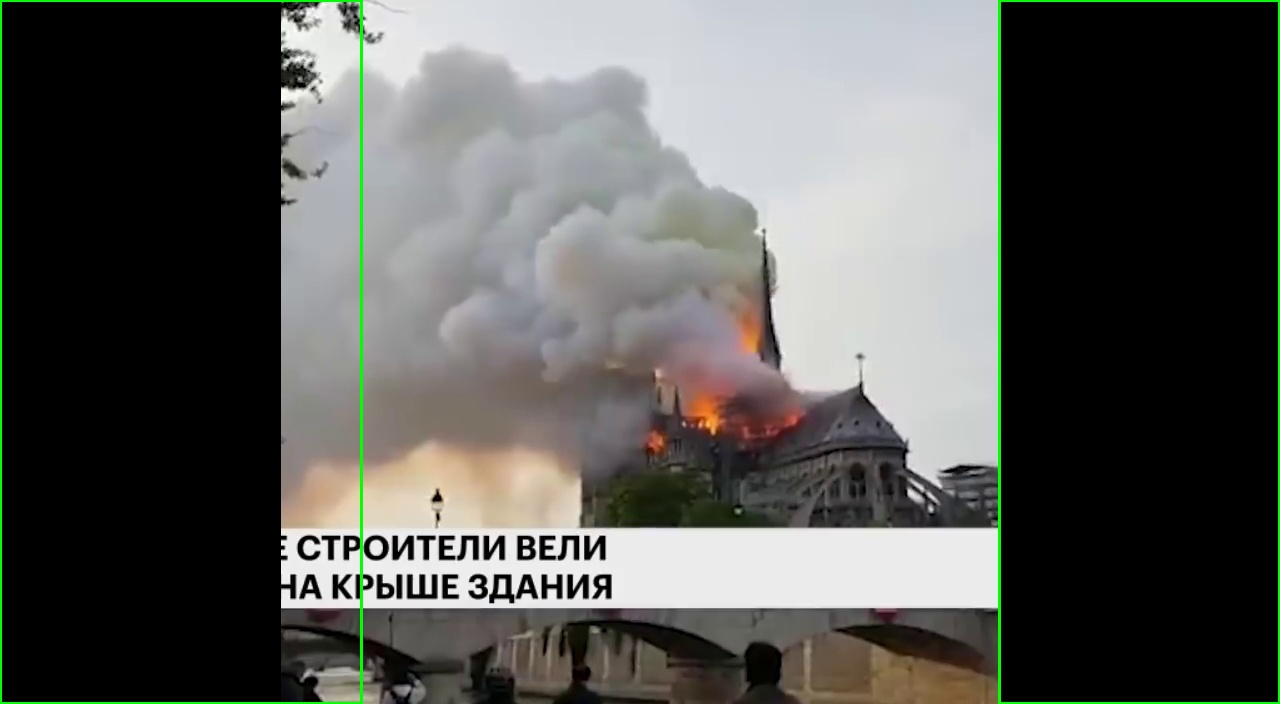

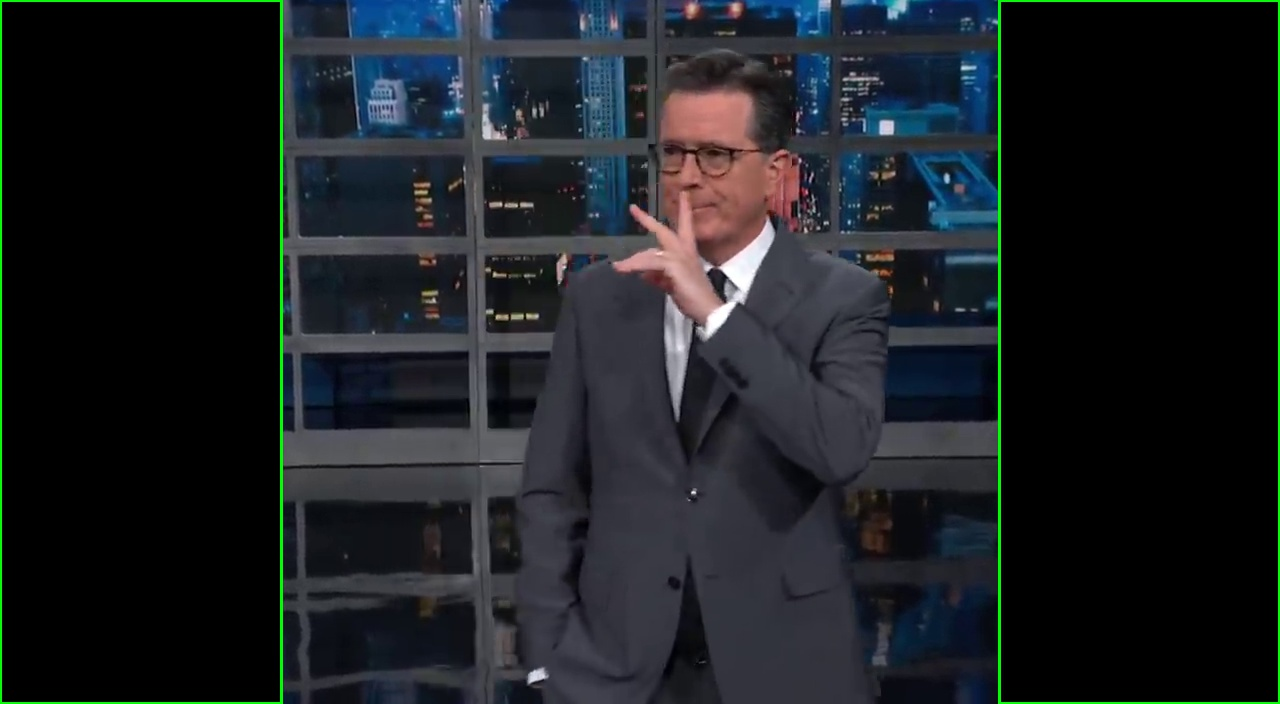

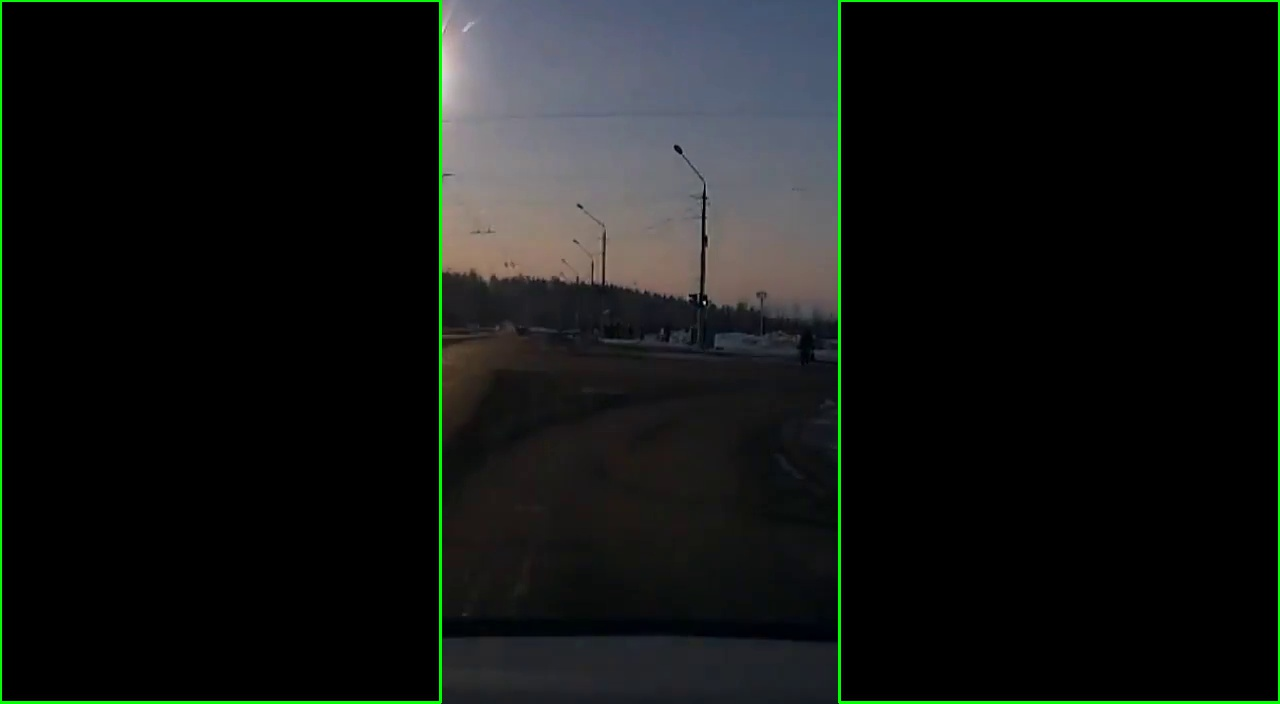

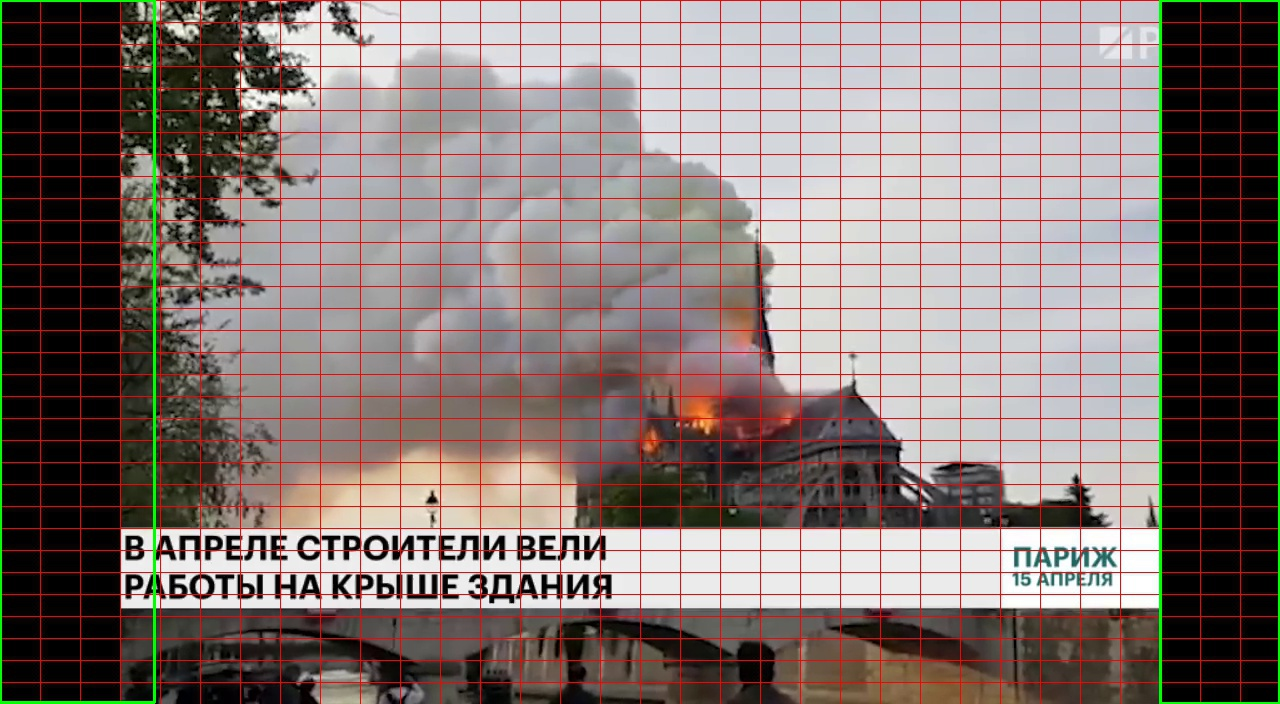

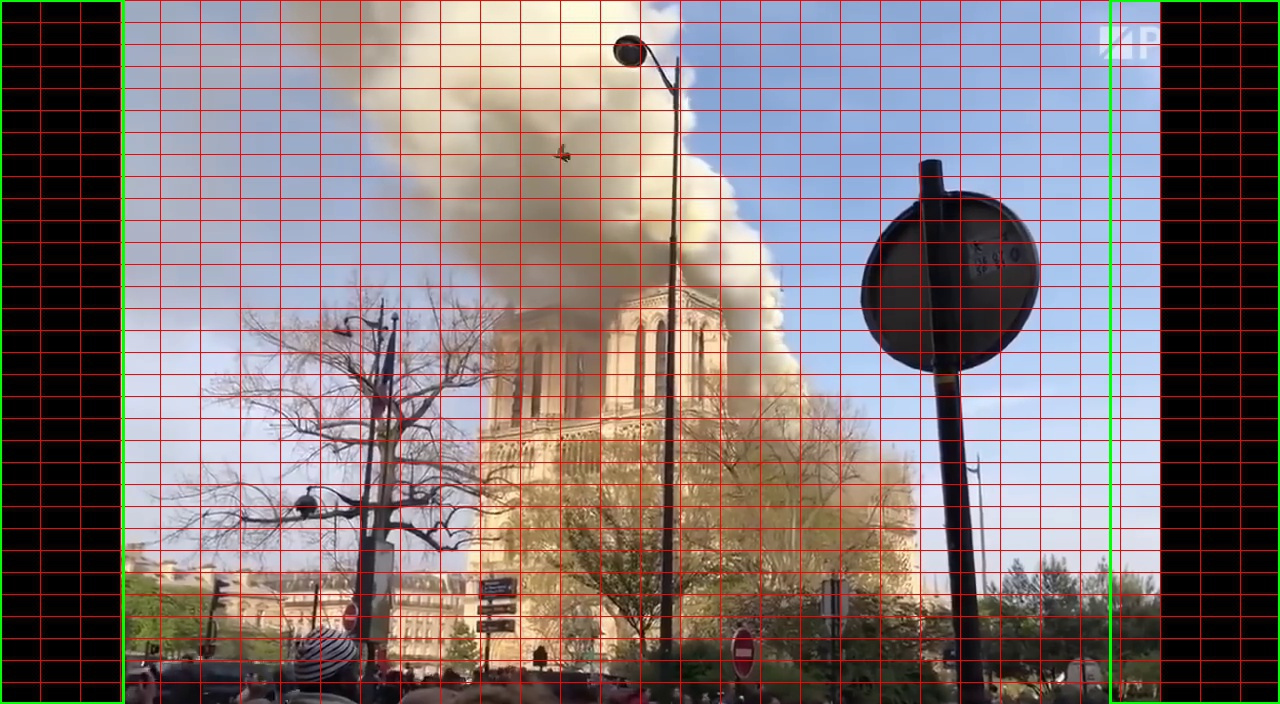

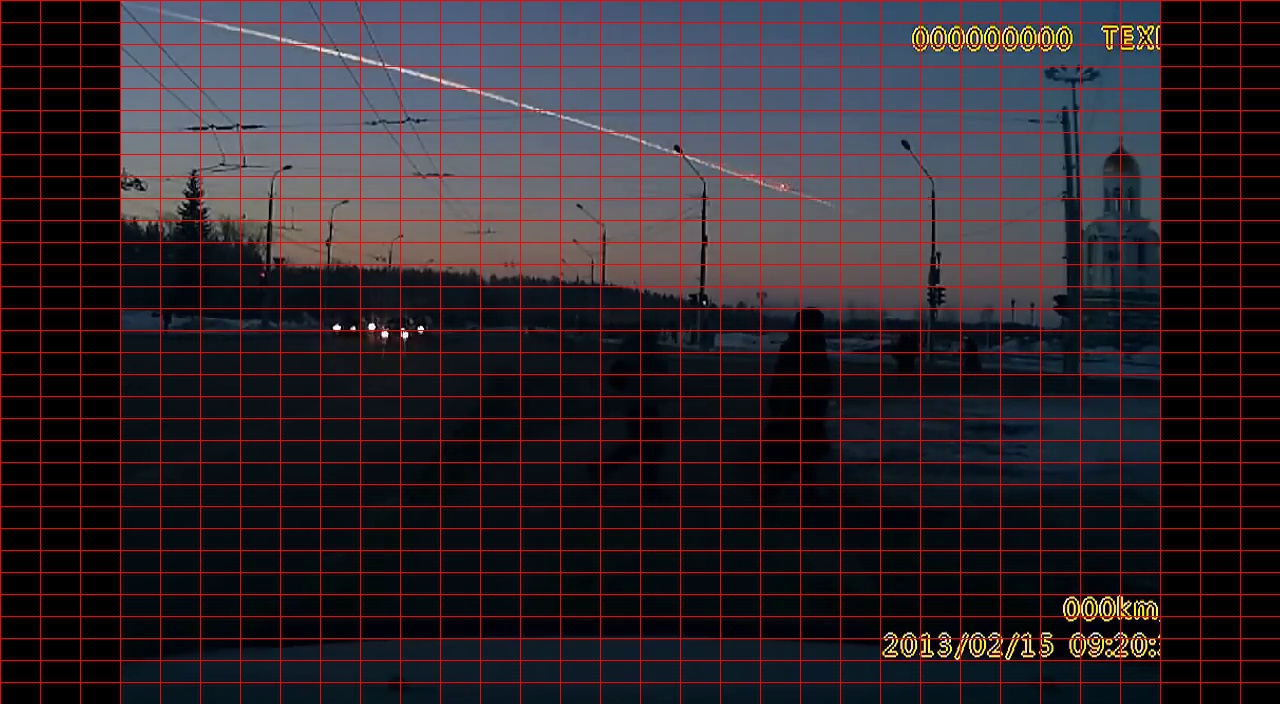

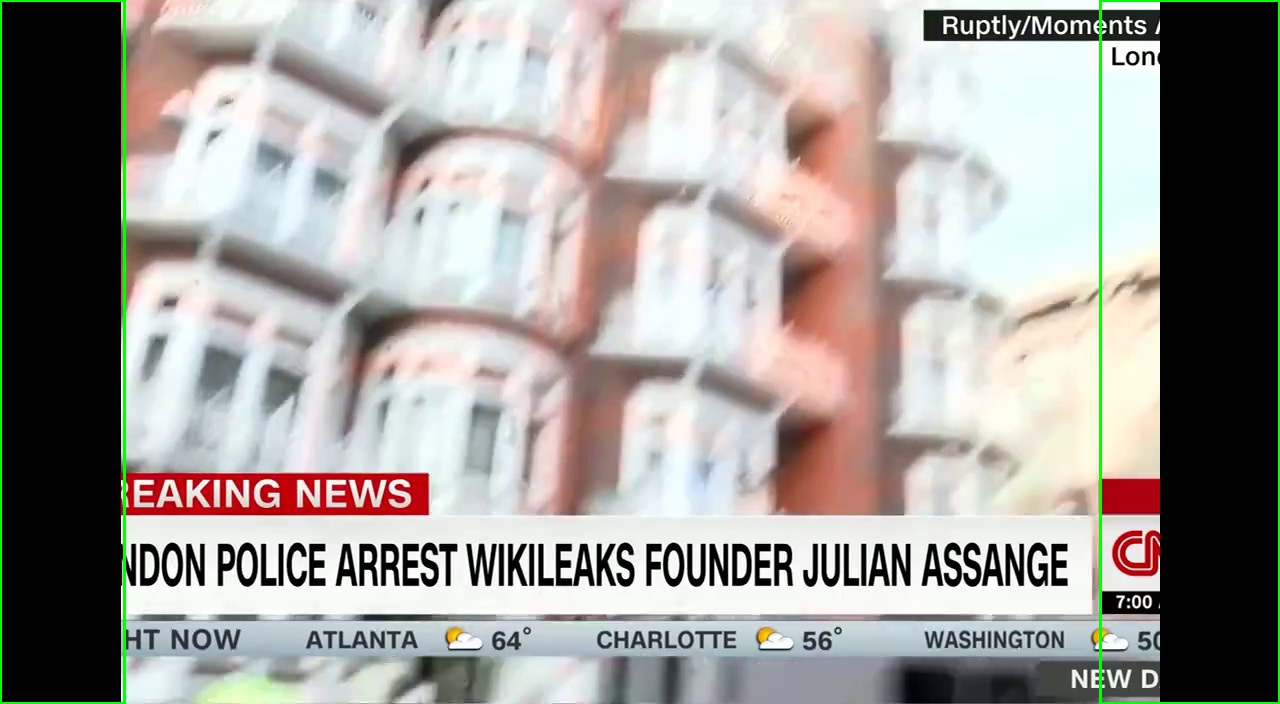

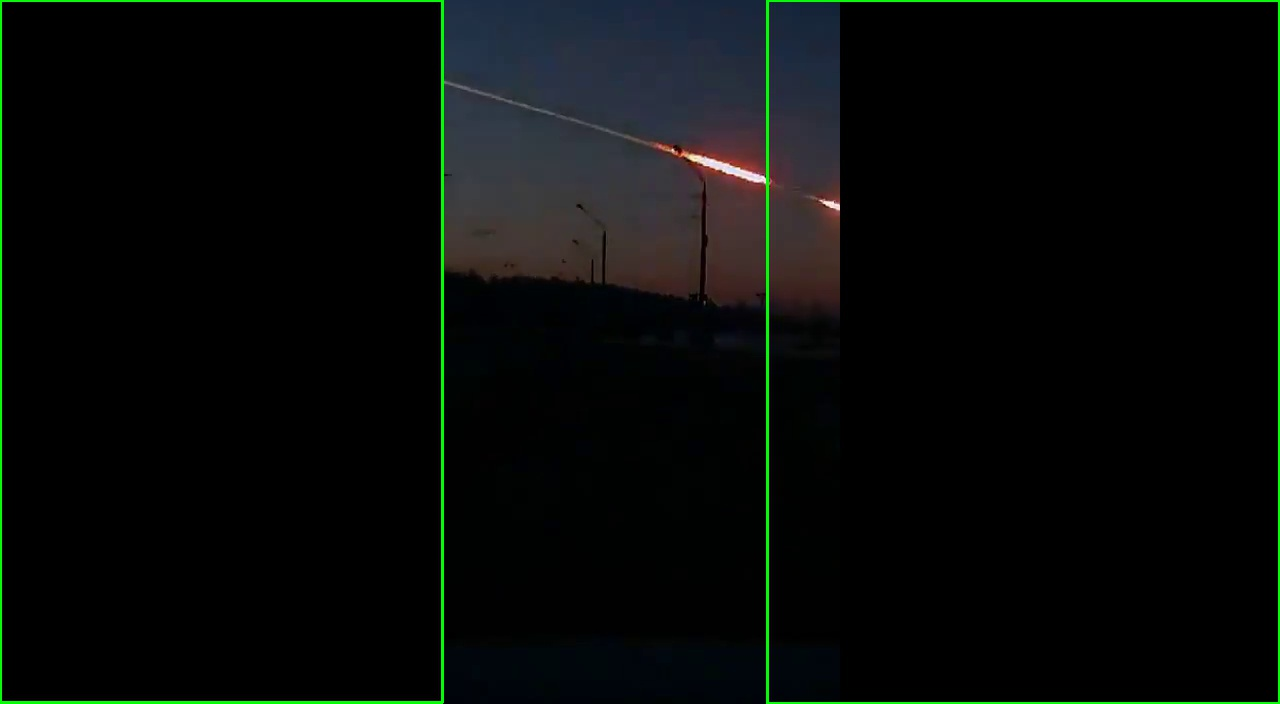

In [ ]:
# Видим, что поиск по контурам работает не очень хорошо. Гаусовское размытие при красной сетке не панацея.
# Области с затемнением мешают нормально найти черные рамки. 
# Плюс на некоторых изображениях даже без затемнения граница заезжает за черные рамки. Этот способ был выбран в качестве эксперимента.
# Вторым вариантом решения будет применение предобученной нейронной сети и трансфер лёнинг.